# BioDeepTime Analysis

Analysis on two diversity metrics are provided: (1) Range-Through (RT) diversity, and (2) Sampled-In-Bin (SIB) diversity, along with the analysis of second-for-third origination and extinction. RT diversity calculates diversity based upon the first and last occurrence of each genera, while SIB diversity is calculated based upon a sample-based rarefaction which attempts to correct for sampling intensities.  

Analysis of Neotoma Data set:
1) All sequences must have > 10 horizons
2) Examining Genera-level diversity
3) Examining Range-through diversity, second-for-third origination, and second-for-third extinction
4) Analysis on each individual time series

Analysis of Planktonic Forams Data set:
1) All sequences must have > 10 horizons
2) Examining Genera-level diversity
3) Examining Range-through diversity, second-for-third origination, and second-for-third extinction
4) Analysis on each individual time series

Note: The below code is only to filter and plot results. Results are saved in the data/Neotoma_Results and data/Plantonic_Results. If you want to analyze full data set directly from BioDeepTime you must run the below scripts: BioDeepTime_Neotoma.R and BioDeepTime_Planktonic_Forams.R. Both of these R scripts are slow and it is recommend you parallalize analysis with at least 10 CPUs.

Remember to set figure save paths for each code chunk below.

In [5]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib import patheffects
import glob
import json

In [ ]:
# Set inital import paths
neotoma_results_path = "../Blind_Review_Code_Repository_2025/data/Neotoma_Results"
plank_results_path = "../Blind_Review_Code_Repository_2025/data/Plantonic_Results"

In [ ]:
# Neotoma: Load all JSON files
json_dir = neotoma_results_path 
full_paths = glob.glob(f"{json_dir}/*.json")

data_list = []

for path in full_paths:
    with open(path, "r") as f:
        series_neo = json.load(f)
    
    # Convert to numeric arrays
    try:
        div_rt_flu = np.array(series_neo["div_rt_fluctuation"], dtype=float)
        div_sib_flu = np.array(series_neo["div_sib_fluctuation"], dtype=float)
        ext_flu = np.array(series_neo["ext_fluctuation"], dtype=float)
        ori_flu = np.array(series_neo["ori_fluctuation"], dtype=float)
        scales = np.array(series_neo["scales"], dtype=float)
    except KeyError:
        continue
    
    # Skip series with NaNs
    if np.isnan(div_rt_flu).any():
        continue
    
    # Length of series
    n = len(scales)
    
    # Build long-format DataFrame
    df_tmp = pd.DataFrame({
        "seriesID": [series_neo["seriesID"][0]]*n,
        "lat": [series_neo["lat"][0]]*n,
        "lon": [series_neo["long"][0]]*n,
        "scale": scales,
        "div_rt_flu": div_rt_flu,
        "div_sib_flu": div_sib_flu,
        "ext_flu": ext_flu,
        "ori_flu": ori_flu
    })
    
    data_list.append(df_tmp)

# Combine all series
haar_df = pd.concat(data_list, ignore_index=True)

In [7]:
# Search data for specific lat lon
lat_bin_mask = (haar_df['lat'] > 55) & (haar_df['lat'] <= 70)
select_series = haar_df.loc[lat_bin_mask, 'seriesID'].unique()

matched_indices = []

for i, path in enumerate(full_paths):
    for sid in select_series:
        # Check if the series ID appears in the filename
        if f"neotoma_{sid}_" in path:
            matched_indices.append(i)
            break  # move to next path once matched
print(f"Sequences within Latitudes: {len(matched_indices)}")

Sequences within Latitudes: 254


Extracting Data for TS_184


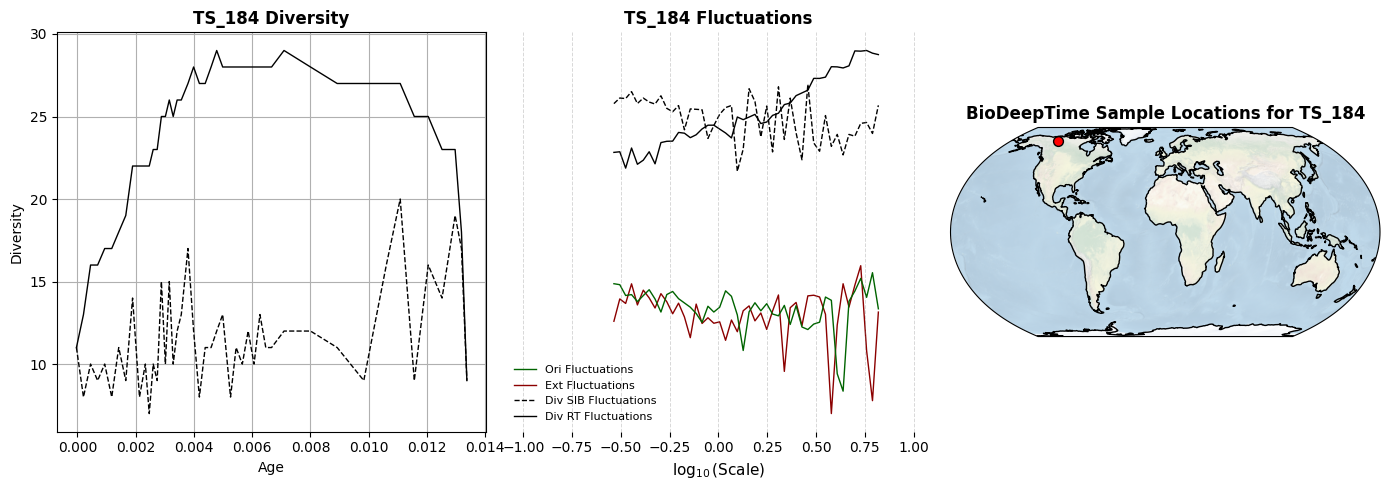

In [ ]:
# Plot individual locality

# Data is stored for each time series in a JSON file
with open(full_paths[matched_indices[0]], "r") as f:
    series_neo = json.load(f)

# Required Data for each series
series_id = str(series_neo["seriesID"][0])
div_rt_flu = np.array(series_neo["div_rt_fluctuation"], dtype=float)

# First check if NAN in data; if so discard
if np.isnan(div_rt_flu).any():
    print("Skipping " + series_id)
    # Add line to skip
else:
    # Extract remaining
    print("Extracting Data for " + series_id)
    latitude = float(series_neo["lat"][0])
    longitude = float(series_neo["long"][0])
    group = str(series_neo["group"][0])

    # Fluctutations
    scale = np.array(series_neo["scales"], dtype=float)
    div_sib_flu = np.array(series_neo["div_sib_fluctuation"], dtype=float)
    ext_flu = np.array(series_neo["ext_fluctuation"], dtype=float)
    ori_flu = np.array(series_neo["ori_fluctuation"], dtype=float)
    # Diveristy Metrics
    div_rt = np.array(series_neo["diversity_rt"], dtype=float)
    div_sib = np.array(series_neo["diversity_sib"], dtype=float)
    age = (np.array(series_neo["Age"], dtype=float) * 1000)/1e6

    # --- Figure setup ---
    fig = plt.figure(figsize=(14,5))

    # First subplot: diversity line
    div_lines = fig.add_subplot(1,3,1)
    div_lines.plot(age, div_rt, label="Div RT", color="black", linewidth=1)
    div_lines.plot(age, div_sib, label="Div SIB", color="black", linewidth=1, linestyle = "dashed")
    div_lines.set_title(f"{series_id} Diversity", fontsize=12, weight="bold")
    div_lines.set_xlabel("Age")
    div_lines.set_ylabel("Diversity")
    div_lines.grid(True)

    # Second subplot: fluctuations
    ax_lines = fig.add_subplot(1,3,2)
    ax_lines.plot(np.log10(scale), np.log10(div_rt_flu), label="Div RT Fluctuations", color="black", linewidth=1)
    ax_lines.plot(np.log10(scale), np.log10(div_sib_flu), label="Div SIB Fluctuations", color="black", linewidth=1, linestyle = "dashed")
    ax_lines.plot(np.log10(scale), np.log10(ext_flu), label="Ext Fluctuations", color="darkred", linewidth=1)
    ax_lines.plot(np.log10(scale), np.log10(ori_flu), label="Ori Fluctuations", color="darkgreen", linewidth=1)

    # Log10 binning vertical lines
    bin_width = 0.25
    global_min = np.log10(scale).min()
    global_max = np.log10(scale).max()
    log_breaks = np.arange(np.floor(global_min), np.ceil(global_max) + bin_width, bin_width)
    for x in log_breaks:
        ax_lines.axvline(x=x, color='gray', linestyle='--', alpha=0.3, linewidth=0.7)

    # Style line plot
    ax_lines.set_xlabel(r'$\log_{10}$(Scale)', fontsize=11)
    ax_lines.set_yticks([])            
    ax_lines.set_yticklabels([])       
    ax_lines.grid(False)               
    ax_lines.set_title(f'{series_id} Fluctuations', fontsize=12, weight='bold')
    for spine in ax_lines.spines.values():
        spine.set_visible(False)

    # Reverse legend order
    handles, labels = ax_lines.get_legend_handles_labels()
    ax_lines.legend(handles[::-1], labels[::-1], fontsize=8, loc='lower left', frameon=False)

    # Third subplot: map
    ax_map = fig.add_subplot(1,3,3, projection=ccrs.EqualEarth())
    ax_map.set_global()
    ax_map.coastlines(resolution='110m', linewidth=1)
    ax_map.stock_img(alpha=0.5)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    ax_map.set_title(f'BioDeepTime Sample Locations for {series_id}', fontsize=12, weight='bold')

    # Scatter sample locations
    ax_map.scatter(longitude, latitude, s=50, alpha=1, transform=ccrs.PlateCarree(),
                color="red", edgecolor='black', linewidth=1)

    plt.tight_layout()


#save_path = f'../Haar_Neotoma_{series_id}.png'
#plt.savefig(save_path, dpi=300)

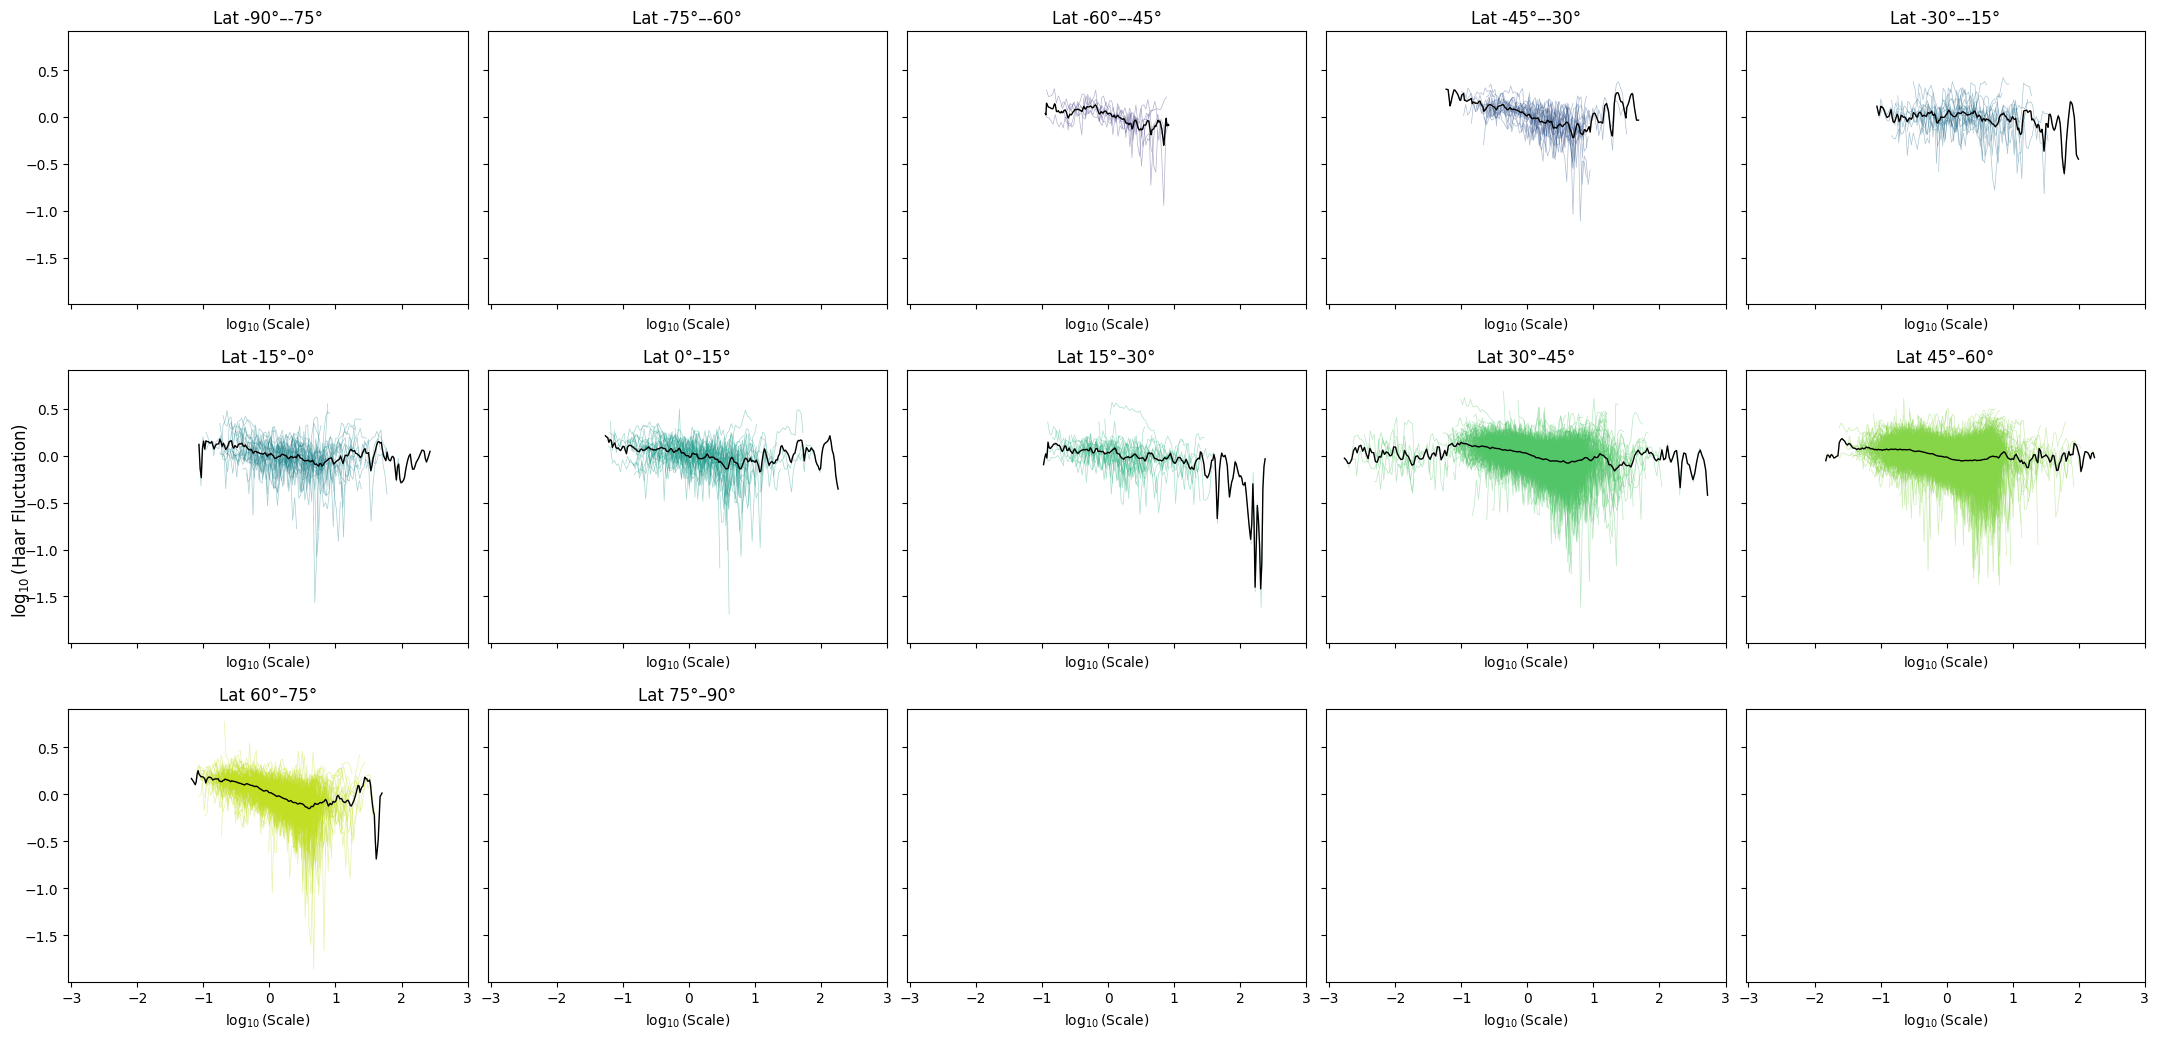

In [ ]:
# Plot global latitudinal averages
# ------------------------
# Define latitude bins and colormap
# ------------------------
lat_bins = np.arange(-90, 91, 15)  # Adjust bin width as needed
haar_df['lat_bin'] = pd.cut(haar_df['lat'], bins=lat_bins)
unique_bins = haar_df['lat_bin'].cat.categories

cmap = plt.get_cmap('viridis')
bin_mids = [b.mid for b in unique_bins]
norm = mcolors.Normalize(vmin=min(bin_mids), vmax=max(bin_mids))
bin_to_color = {bin_: cmap(norm(bin_.mid)) for bin_ in unique_bins}

# ------------------------
# Create subplots
# ------------------------
n_bins = len(unique_bins)
n_cols = 5
n_rows = int(np.ceil(n_bins / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4 + 1.5, n_rows*3 + 1.5), sharex=True, sharey=True)
axes = axes.flatten()

for i, lat_bin in enumerate(unique_bins):
    df_bin = haar_df[haar_df['lat_bin'] == lat_bin]
    
    all_scales = []
    all_centered = []

    # Plot each series separately
    for series_id, df_series in df_bin.groupby('seriesID'):
        df_series_sorted = df_series.sort_values('scale')
        log_scale = np.log10(df_series_sorted['scale'].values)
        log_flu = np.log10(df_series_sorted['div_sib_flu'].values)
        log_flu_centered = log_flu - np.mean(log_flu)
        
        axes[i].plot(
            log_scale,
            log_flu_centered,
            alpha=0.4,
            color=bin_to_color[lat_bin],
            linewidth=0.5
        )
        
        # store for mean line
        all_scales.append(log_scale)
        all_centered.append(log_flu_centered)
    
    # Compute mean line by interpolating to common log10(scale) grid
    if all_scales:
        # Define common scale grid
        common_scale = np.linspace(min([s.min() for s in all_scales]),
                                   max([s.max() for s in all_scales]), 200)
        interpolated = []
        for s, f in zip(all_scales, all_centered):
            f_interp = interp1d(s, f, kind='linear', bounds_error=False, fill_value=np.nan)
            interpolated.append(f_interp(common_scale))
        
        # Take mean across series, ignoring NaNs
        mean_line = np.nanmean(np.array(interpolated), axis=0)
        
        axes[i].plot(
            common_scale,
            mean_line,
            color='black',
            linewidth=1,
            label='Mean'
        )
    
    axes[i].set_title(f'Lat {int(lat_bin.left)}°–{int(lat_bin.right)}°')
    axes[i].grid(False)

# Common axis labels
#fig.text(0.5, 0, r'$\log_{10}$(Scale)', ha='center', fontsize=12)
fig.text(0, 0.5, r'$\log_{10}$(Haar Fluctuation)', va='center', rotation='vertical', fontsize=12)

for ax in axes:
    ax.set_xlabel(r'$\log_{10}$(Scale)', fontsize=10)
    
plt.tight_layout()

#save_path = f'../Neotoma_Haar_divSIB_Subplots.png'
#plt.savefig(save_path, dpi=300)


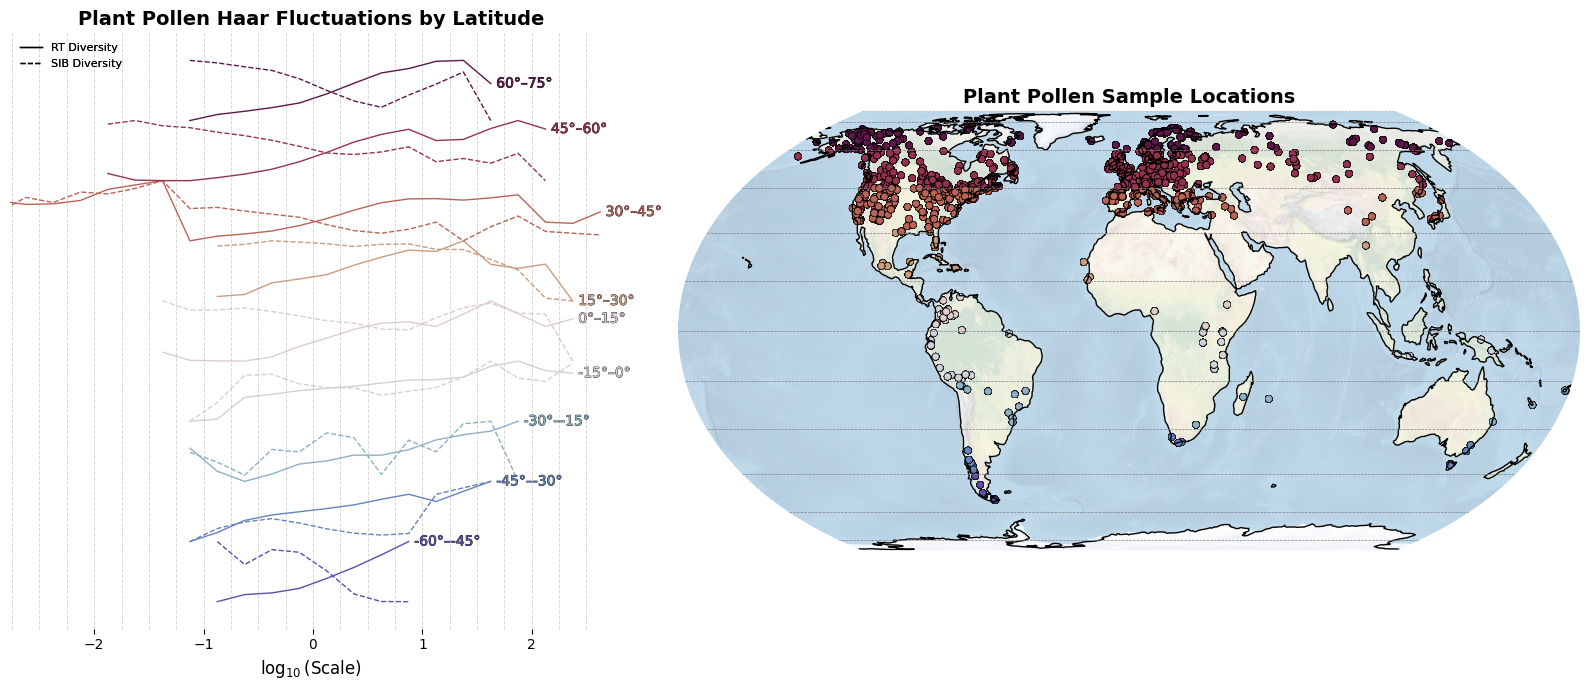

In [ ]:
# Plot global latitudinal averages allow with locations
# ------------------------
# Setup: latitude bins & colormap
# ------------------------
haar_df = haar_df[haar_df['scale'] > 0]

lat_bins = np.arange(-90, 91, 15)
haar_df['lat_bin'] = pd.cut(haar_df['lat'], bins=lat_bins)
unique_bins = haar_df['lat_bin'].cat.categories

# Use twilight_shifted colormap
cmap = plt.get_cmap('twilight_shifted')
bin_mids = [b.mid for b in unique_bins]
norm = mcolors.Normalize(vmin=min(bin_mids), vmax=max(bin_mids))
bin_to_color = {bin_: cmap(norm(bin_.mid)) for bin_ in unique_bins}

# ------------------------
# Figure setup
# ------------------------
fig, (ax_lines, ax_map) = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 7),
    gridspec_kw={'width_ratios': [1, 1.5]}
)
plt.subplots_adjust(wspace=0.15)  # reduce spacing

# Common log10 binning
bin_width = 0.25
global_min = np.log10(haar_df['scale']).min()
global_max = np.log10(haar_df['scale']).max()
log_breaks = np.arange(np.floor(global_min), np.ceil(global_max) + bin_width, bin_width)

# ------------------------
# Plot stacked mean lines per latitude bin
# ------------------------
for i, lat_bin in enumerate(unique_bins):
    df_bin = haar_df[haar_df['lat_bin'] == lat_bin].copy()
    if df_bin.empty:
        continue

    color = bin_to_color[lat_bin]

    # ------------------------
    # RT Diversity
    # ------------------------
    df_bin['log_scale'] = np.log10(df_bin['scale'])
    df_bin['log_flu_rt'] = np.log10(df_bin['div_rt_flu'])

    df_bin['log_bin'] = pd.cut(df_bin['log_scale'], bins=log_breaks, include_lowest=True)
    agg_df_rt = df_bin.groupby('log_bin', observed=True)['log_flu_rt'].mean().reset_index()
    agg_df_rt['mid_points'] = agg_df_rt['log_bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

    y_rt = agg_df_rt['log_flu_rt'].values
    y_rt = (y_rt - np.nanmin(y_rt)) / (np.nanmax(y_rt) - np.nanmin(y_rt))
    y_offset = i
    y_plot_rt = y_rt + y_offset

    ax_lines.plot(
        agg_df_rt['mid_points'],
        y_plot_rt,
        color=color,
        lw=1,
        alpha=1,
        label=None
    )

    # Add inline label with black outline
    ax_lines.text(
        x=agg_df_rt['mid_points'].iloc[-1] + 0.05,
        y=y_plot_rt[-1],
        s=f"{int(lat_bin.left)}°–{int(lat_bin.right)}°",
        color=color,
        fontsize=10,
        va='center',
        path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')]
    )

    # ------------------------
    # SIB Diversity (dashed)
    # ------------------------
    df_bin['log_flu_sib'] = np.log10(df_bin['div_sib_flu'])

    agg_df_sib = df_bin.groupby('log_bin', observed=True)['log_flu_sib'].mean().reset_index()
    agg_df_sib['mid_points'] = agg_df_sib['log_bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

    y_sib = agg_df_sib['log_flu_sib'].values
    y_sib = (y_sib - np.nanmin(y_sib)) / (np.nanmax(y_sib) - np.nanmin(y_sib))
    y_plot_sib = y_sib + y_offset

    ax_lines.plot(
        agg_df_sib['mid_points'],
        y_plot_sib,
        color=color,
        lw=1,
        alpha=1,
        linestyle='dashed'
    )

# ------------------------
# Vertical dashed lines for x-axis
# ------------------------
for x in log_breaks:
    ax_lines.axvline(x=x, color='gray', linestyle='--', alpha=0.3, linewidth=0.7)

# Remove the frame/box around map 
if hasattr(ax_map, 'outline_patch') and ax_map.outline_patch is not None: ax_map.outline_patch.set_edgecolor('none')
ax_map.set_frame_on(False) 
ax_map.set_xticks([]) 
ax_map.set_yticks([])

# ------------------------
# Style line plot
# ------------------------
ax_lines.set_xlabel(r'$\log_{10}$(Scale)', fontsize=12)
ax_lines.set_yticks([])
ax_lines.set_yticklabels([])
ax_lines.set_xlim(global_min, global_max)
ax_lines.grid(False)
ax_lines.set_title('Plant Pollen Haar Fluctuations by Latitude', fontsize=14, weight='bold')
for spine in ax_lines.spines.values():
    spine.set_visible(False)

# Proxy lines for dashed/solid legend inside plot
rt_line = mlines.Line2D([], [], color='black', linewidth=1, label='RT Diversity')
sib_line = mlines.Line2D([], [], color='black', linewidth=1, linestyle='dashed', label='SIB Diversity')
legend1 = ax_lines.legend(handles=[rt_line, sib_line], fontsize=8, loc='upper left', frameon=False)
ax_lines.add_artist(legend1)

# ------------------------
# Map subplot
# ------------------------
ax_map = plt.subplot(1, 2, 2, projection=ccrs.EqualEarth())
ax_map.set_global()
ax_map.coastlines(resolution='110m', linewidth=1)
ax_map.stock_img(alpha=0.5)
ax_map.set_title('Plant Pollen Sample Locations', fontsize=14, weight='bold')

# Plot latitude lines for alignment
for lat in lat_bins:
    ax_map.plot([-180, 180], [lat, lat], color='gray', linestyle='--', linewidth=0.5, transform=ccrs.PlateCarree())

# Scatter sample locations
longs = haar_df['lon']
lats = haar_df['lat']
colors = [bin_to_color.get(bin_, (0, 0, 0, 1)) for bin_ in haar_df['lat_bin']]
ax_map.scatter(longs, lats, s=25, alpha=1, transform=ccrs.PlateCarree(),
               color=colors, edgecolor='black', linewidth=0.3)

ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_frame_on(False)

plt.tight_layout()

#save_path = f'../Haar_BioDeepTime_Neotoma_2025.png'
#plt.savefig(save_path, dpi=300)

### Planktonic Forams

In [15]:
# Planktonic Forams: Load all JSON files

# ------------------------
# Load all JSON files
# ------------------------
json_dir = plank_results_path 
full_paths_plank = glob.glob(f"{json_dir}/*.json")

data_list = []

for path in full_paths_plank:
    with open(path, "r") as f:
        series_neo = json.load(f)
    
    # Convert to numeric arrays
    try:
        div_rt_flu = np.array(series_neo["div_rt_fluctuation"], dtype=float)
        div_sib_flu = np.array(series_neo["div_sib_fluctuation"], dtype=float)
        ext_flu = np.array(series_neo["ext_fluctuation"], dtype=float)
        ori_flu = np.array(series_neo["ori_fluctuation"], dtype=float)
        scales = np.array(series_neo["scales"], dtype=float)
    except KeyError:
        continue
    
    # Skip series with NaNs
    if np.isnan(div_rt_flu).any():
        continue
    
    # Length of series
    n = len(scales)
    
    # Build long-format DataFrame
    df_tmp = pd.DataFrame({
        "seriesID": [series_neo["seriesID"][0]]*n,
        "lat": [series_neo["lat"][0]]*n,
        "lon": [series_neo["long"][0]]*n,
        "scale": scales,
        "div_rt_flu": div_rt_flu,
        "div_sib_flu": div_sib_flu,
        "ext_flu": ext_flu,
        "ori_flu": ori_flu
    })
    
    data_list.append(df_tmp)

# Combine all series
haar_df_plank = pd.concat(data_list, ignore_index=True)

In [16]:
# Search data for specific lat lon
lat_bin_mask = (haar_df_plank['lat'] > 55) & (haar_df_plank['lat'] <= 75)
select_series = haar_df_plank.loc[lat_bin_mask, 'seriesID'].unique()

matched_indices = []

for i, path in enumerate(full_paths_plank):
    for sid in select_series:
        # Check if the series ID appears in the filename
        if f"planktonic_{sid}_" in path:
            matched_indices.append(i)
            break  # move to next path once matched

print(f"Sequences within Latitudes: {len(matched_indices)}")

Sequences within Latitudes: 29


Extracting Data for TS_9583


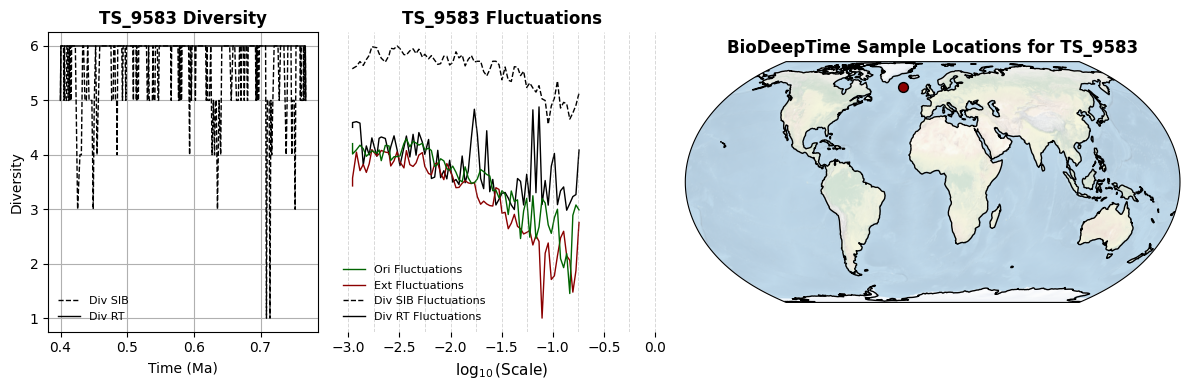

In [17]:
# Data is stored for each time series in a JSON file
with open(full_paths_plank[matched_indices[25]], "r") as f:
    series_neo = json.load(f)

# Required Data for each series
series_id = str(series_neo["seriesID"][0])
div_rt_flu = np.array(series_neo["div_rt_fluctuation"], dtype=float)

# First check if NAN in data; if so discard
if np.isnan(div_rt_flu).any():
    print("Skipping " + series_id)
    # Add line to skip
else:
    # Extract remaining
    print("Extracting Data for " + series_id)
    latitude = float(series_neo["lat"][0])
    longitude = float(series_neo["long"][0])
    group = str(series_neo["group"][0])

    # Fluctutations
    scale = np.array(series_neo["scales"], dtype=float)
    div_sib_flu = np.array(series_neo["div_sib_fluctuation"], dtype=float)
    ext_flu = np.array(series_neo["ext_fluctuation"], dtype=float)
    ori_flu = np.array(series_neo["ori_fluctuation"], dtype=float)
    # Diveristy Metrics
    div_rt = np.array(series_neo["diversity_rt"], dtype=float)
    div_sib = np.array(series_neo["diversity_sib"], dtype=float)
    age = (np.array(series_neo["Age"], dtype=float))

    # --- Figure setup ---
    fig = plt.figure(figsize=(12,4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1.5, 2.2])

    # First subplot: diversity line
    div_lines = fig.add_subplot(gs[0, 0])
    div_lines.plot(age, div_rt, label="Div RT", color="black", linewidth=1)
    div_lines.plot(age, div_sib, label="Div SIB", color="black", linewidth=1, linestyle = "dashed")
    div_lines.set_title(f"{series_id} Diversity", fontsize=12, weight="bold")
    div_lines.set_xlabel("Time (Ma)")
    div_lines.set_ylabel("Diversity")
    div_lines.grid(True)

    # Second subplot: fluctuations
    ax_lines = fig.add_subplot(gs[0, 1])
    ax_lines.plot(np.log10(scale), np.log10(div_rt_flu), label="Div RT Fluctuations", color="black", linewidth=1)
    ax_lines.plot(np.log10(scale), np.log10(div_sib_flu), label="Div SIB Fluctuations", color="black", linewidth=1, linestyle = "dashed")
    ax_lines.plot(np.log10(scale), np.log10(ext_flu), label="Ext Fluctuations", color="darkred", linewidth=1)
    ax_lines.plot(np.log10(scale), np.log10(ori_flu), label="Ori Fluctuations", color="darkgreen", linewidth=1)

    # Log10 binning vertical lines
    bin_width = 0.25
    global_min = np.log10(scale).min()
    global_max = np.log10(scale).max()
    log_breaks = np.arange(np.floor(global_min), np.ceil(global_max) + bin_width, bin_width)
    for x in log_breaks:
        ax_lines.axvline(x=x, color='gray', linestyle='--', alpha=0.3, linewidth=0.7)

    # Style line plot
    ax_lines.set_xlabel(r'$\log_{10}$(Scale)', fontsize=11)
    ax_lines.set_yticks([])            
    ax_lines.set_yticklabels([])       
    ax_lines.grid(False)               
    ax_lines.set_title(f'{series_id} Fluctuations', fontsize=12, weight='bold')
    for spine in ax_lines.spines.values():
        spine.set_visible(False)

    # Reverse legend order
    handles, labels = ax_lines.get_legend_handles_labels()
    ax_lines.legend(handles[::-1], labels[::-1], fontsize=8, loc='lower left', frameon=False)

    handles, labels = div_lines.get_legend_handles_labels()
    div_lines.legend(handles[::-1], labels[::-1], fontsize=8, loc='lower left', frameon=False)

    # Third subplot: map
    ax_map = fig.add_subplot(gs[0, 2], projection=ccrs.EqualEarth())
    ax_map.set_global()
    ax_map.coastlines(resolution='110m', linewidth=1)
    ax_map.stock_img(alpha=0.5)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    ax_map.set_title(f'BioDeepTime Sample Locations for {series_id}', fontsize=12, weight='bold')

    # Scatter sample locations
    ax_map.scatter(longitude, latitude, s=50, alpha=1, transform=ccrs.PlateCarree(),
                color="darkred", edgecolor='black', linewidth=1)

    plt.tight_layout()

#save_path = f'../Haar_Foram_{series_id}.png'
#plt.savefig(save_path, dpi=300)

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71182/2856042100.py:60: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.array(interpolated), axis=0)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71182/2856042100.py:60: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.array(interpolated), axis=0)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71182/2856042100.py:60: RuntimeWarning: Mean of empty slice
  mean_line = np.nanmean(np.array(interpolated), axis=0)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71182/2856042100.py:33: RuntimeWarning: divide by zero encountered in log10
  log_scale = np.log10(df_series_sorted['scale'].values)
/opt/anaconda3/envs/climate/lib/python3.13/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/anaconda3/envs/climate/lib/python3.13/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value en

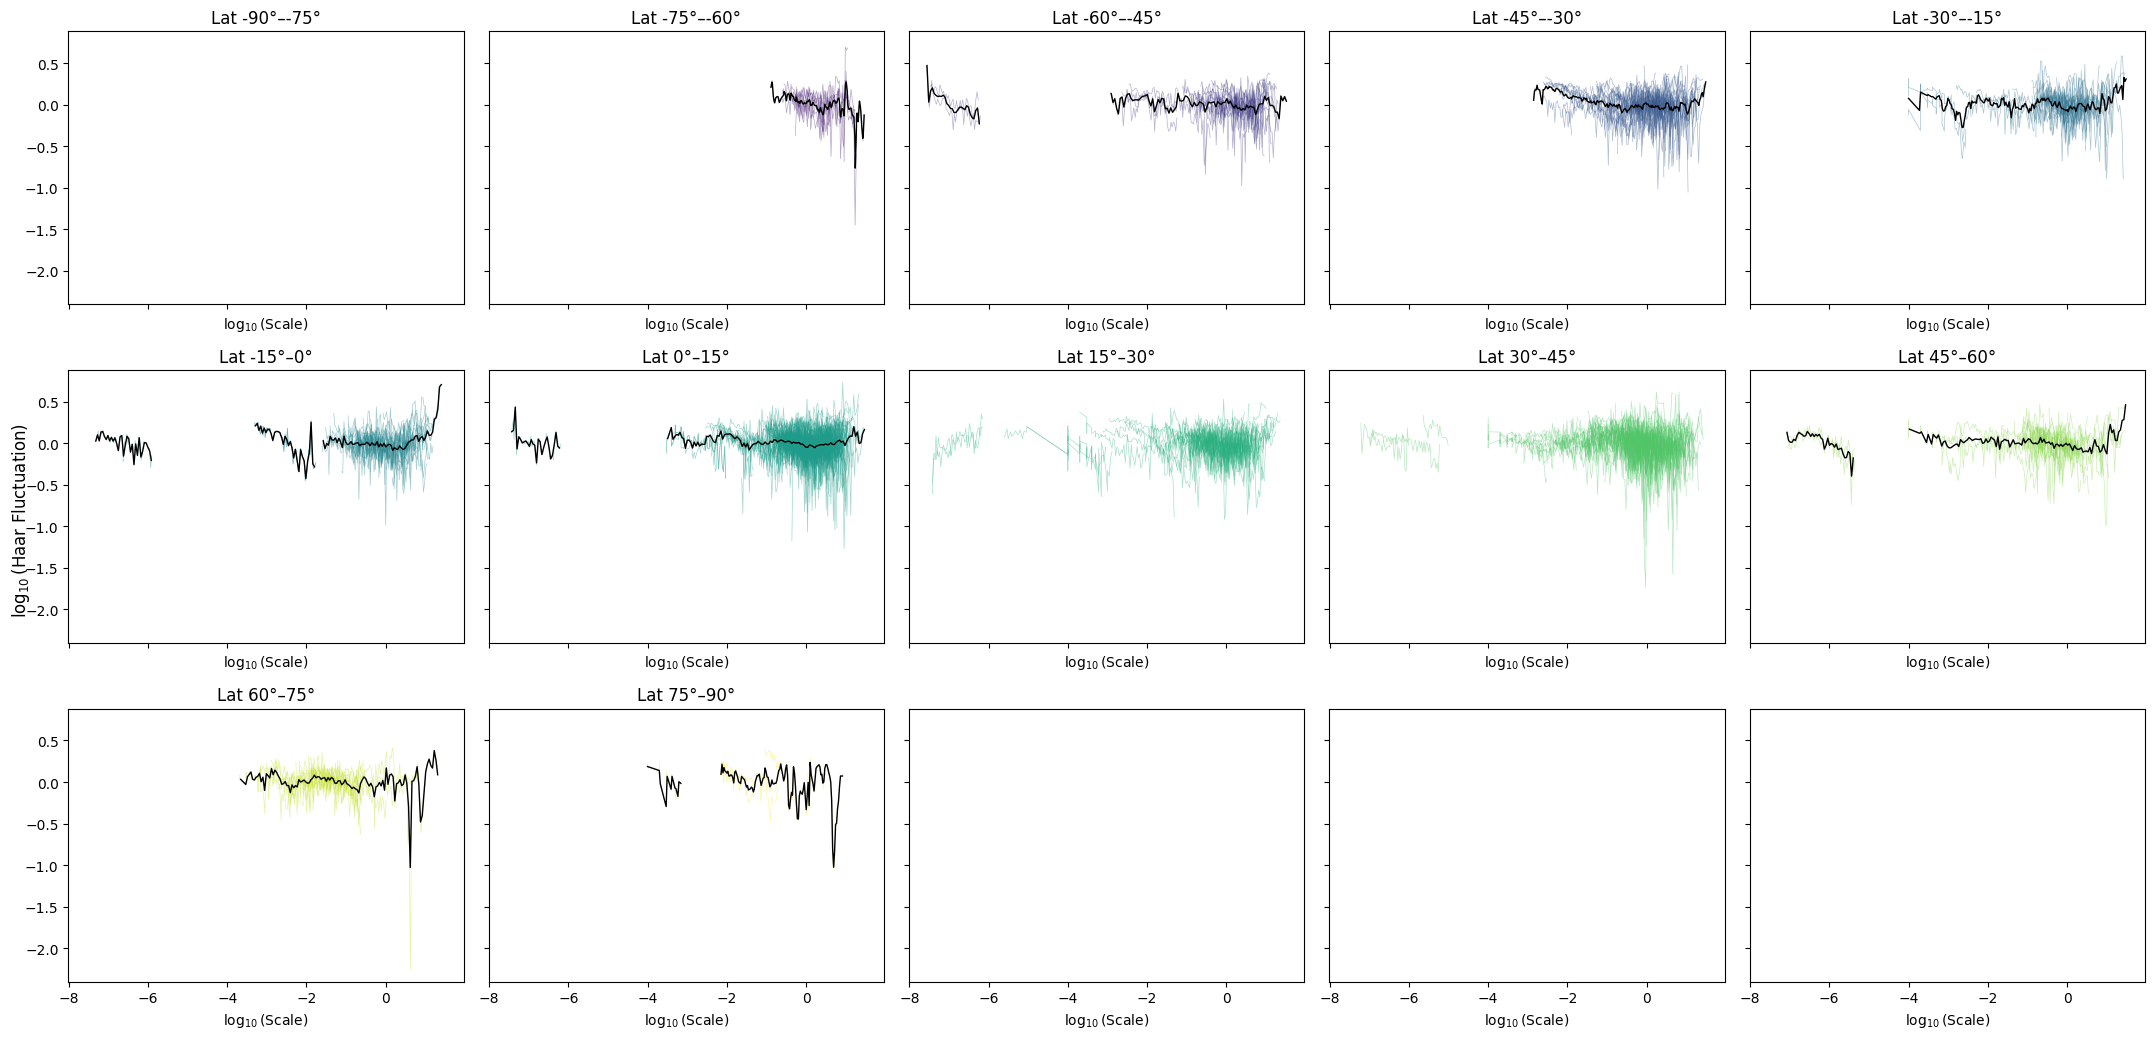

In [18]:
# Plot global latitudinal averages

# ------------------------
# Define latitude bins and colormap
# ------------------------
lat_bins = np.arange(-90, 91, 15)  # Adjust bin width as needed
haar_df_plank['lat_bin'] = pd.cut(haar_df_plank['lat'], bins=lat_bins)
unique_bins = haar_df_plank['lat_bin'].cat.categories

cmap = plt.get_cmap('viridis')
bin_mids = [b.mid for b in unique_bins]
norm = mcolors.Normalize(vmin=min(bin_mids), vmax=max(bin_mids))
bin_to_color = {bin_: cmap(norm(bin_.mid)) for bin_ in unique_bins}

# ------------------------
# Create subplots
# ------------------------
n_bins = len(unique_bins)
n_cols = 5
n_rows = int(np.ceil(n_bins / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4 + 1.5, n_rows*3 + 1.5), sharex=True, sharey=True)
axes = axes.flatten()

for i, lat_bin in enumerate(unique_bins):
    df_bin = haar_df_plank[haar_df_plank['lat_bin'] == lat_bin]
    
    all_scales = []
    all_centered = []

    # Plot each series separately
    for series_id, df_series in df_bin.groupby('seriesID'):
        df_series_sorted = df_series.sort_values('scale')
        log_scale = np.log10(df_series_sorted['scale'].values)
        log_flu = np.log10(df_series_sorted['div_sib_flu'].values)
        log_flu_centered = log_flu - np.mean(log_flu)
        
        axes[i].plot(
            log_scale,
            log_flu_centered,
            alpha=0.4,
            color=bin_to_color[lat_bin],
            linewidth=0.5
        )
        
        # store for mean line
        all_scales.append(log_scale)
        all_centered.append(log_flu_centered)
    
    # Compute mean line by interpolating to common log10(scale) grid
    if all_scales:
        # Define common scale grid
        common_scale = np.linspace(min([s.min() for s in all_scales]),
                                   max([s.max() for s in all_scales]), 200)
        interpolated = []
        for s, f in zip(all_scales, all_centered):
            f_interp = interp1d(s, f, kind='linear', bounds_error=False, fill_value=np.nan)
            interpolated.append(f_interp(common_scale))
        
        # Take mean across series, ignoring NaNs
        mean_line = np.nanmean(np.array(interpolated), axis=0)
        
        axes[i].plot(
            common_scale,
            mean_line,
            color='black',
            linewidth=1,
            label='Mean'
        )
    
    axes[i].set_title(f'Lat {int(lat_bin.left)}°–{int(lat_bin.right)}°')
    axes[i].grid(False)

# Common axis labels
#fig.text(0.5, 0, r'$\log_{10}$(Scale)', ha='center', fontsize=12)
fig.text(0, 0.5, r'$\log_{10}$(Haar Fluctuation)', va='center', rotation='vertical', fontsize=12)

for ax in axes:
    ax.set_xlabel(r'$\log_{10}$(Scale)', fontsize=10)
    
plt.tight_layout()

#save_path = f'../Foram_Haar_divSIB_Subplots.png'
#plt.savefig(save_path, dpi=300)

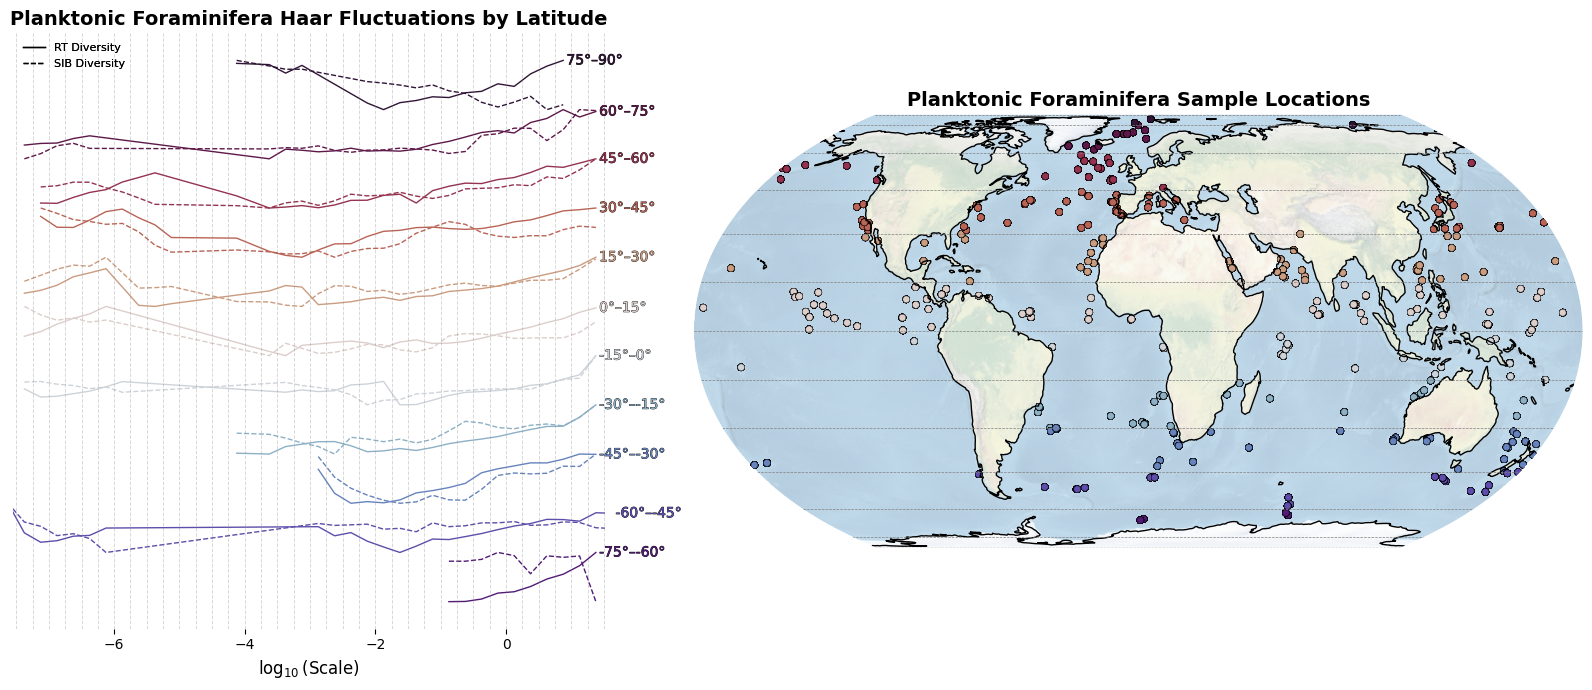

In [19]:
# Plot global latitudinal averages allow with locations

# ------------------------
# Setup: latitude bins & colormap
# ------------------------
haar_df_plank = haar_df_plank[haar_df_plank['scale'] > 0]

lat_bins = np.arange(-90, 91, 15)
haar_df_plank['lat_bin'] = pd.cut(haar_df_plank['lat'], bins=lat_bins)
unique_bins = haar_df_plank['lat_bin'].cat.categories

# Use twilight_shifted colormap
cmap = plt.get_cmap('twilight_shifted')
bin_mids = [b.mid for b in unique_bins]
norm = mcolors.Normalize(vmin=min(bin_mids), vmax=max(bin_mids))
bin_to_color = {bin_: cmap(norm(bin_.mid)) for bin_ in unique_bins}

# ------------------------
# Figure setup
# ------------------------
fig, (ax_lines, ax_map) = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 7),
    gridspec_kw={'width_ratios': [1, 1.5]}
)
plt.subplots_adjust(wspace=0.15)  # reduce spacing

# Common log10 binning
bin_width = 0.25
global_min = np.log10(haar_df_plank['scale']).min()
global_max = np.log10(haar_df_plank['scale']).max()
log_breaks = np.arange(np.floor(global_min), np.ceil(global_max) + bin_width, bin_width)

# ------------------------
# Plot stacked mean lines per latitude bin
# ------------------------
for i, lat_bin in enumerate(unique_bins):
    df_bin = haar_df_plank[haar_df_plank['lat_bin'] == lat_bin].copy()
    if df_bin.empty:
        continue

    color = bin_to_color[lat_bin]

    # ------------------------
    # RT Diversity
    # ------------------------
    df_bin['log_scale'] = np.log10(df_bin['scale'])
    df_bin['log_flu_rt'] = np.log10(df_bin['div_rt_flu'])

    df_bin['log_bin'] = pd.cut(df_bin['log_scale'], bins=log_breaks, include_lowest=True)
    agg_df_rt = df_bin.groupby('log_bin', observed=True)['log_flu_rt'].mean().reset_index()
    agg_df_rt['mid_points'] = agg_df_rt['log_bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

    y_rt = agg_df_rt['log_flu_rt'].values
    y_rt = (y_rt - np.nanmin(y_rt)) / (np.nanmax(y_rt) - np.nanmin(y_rt))
    y_offset = i
    y_plot_rt = y_rt + y_offset

    ax_lines.plot(
        agg_df_rt['mid_points'],
        y_plot_rt,
        color=color,
        lw=1,
        alpha=1,
        label=None
    )

    # Add inline label with black outline
    ax_lines.text(
        x=agg_df_rt['mid_points'].iloc[-1] + 0.05,
        y=y_plot_rt[-1],
        s=f"{int(lat_bin.left)}°–{int(lat_bin.right)}°",
        color=color,
        fontsize=10,
        va='center',
        path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')]
    )

    # ------------------------
    # SIB Diversity (dashed)
    # ------------------------
    df_bin['log_flu_sib'] = np.log10(df_bin['div_sib_flu'])

    agg_df_sib = df_bin.groupby('log_bin', observed=True)['log_flu_sib'].mean().reset_index()
    agg_df_sib['mid_points'] = agg_df_sib['log_bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

    y_sib = agg_df_sib['log_flu_sib'].values
    y_sib = (y_sib - np.nanmin(y_sib)) / (np.nanmax(y_sib) - np.nanmin(y_sib))
    y_plot_sib = y_sib + y_offset

    ax_lines.plot(
        agg_df_sib['mid_points'],
        y_plot_sib,
        color=color,
        lw=1,
        alpha=1,
        linestyle='dashed'
    )

# ------------------------
# Vertical dashed lines for x-axis
# ------------------------
for x in log_breaks:
    ax_lines.axvline(x=x, color='gray', linestyle='--', alpha=0.3, linewidth=0.7)

# Remove the frame/box around map 
if hasattr(ax_map, 'outline_patch') and ax_map.outline_patch is not None: ax_map.outline_patch.set_edgecolor('none')
ax_map.set_frame_on(False) 
ax_map.set_xticks([]) 
ax_map.set_yticks([])

# ------------------------
# Style line plot
# ------------------------
ax_lines.set_xlabel(r'$\log_{10}$(Scale)', fontsize=12)
ax_lines.set_yticks([])
ax_lines.set_yticklabels([])
ax_lines.set_xlim(global_min, global_max)
ax_lines.grid(False)
ax_lines.set_title('Planktonic Foraminifera Haar Fluctuations by Latitude', fontsize=14, weight='bold')
for spine in ax_lines.spines.values():
    spine.set_visible(False)

# Proxy lines for dashed/solid legend inside plot
rt_line = mlines.Line2D([], [], color='black', linewidth=1, label='RT Diversity')
sib_line = mlines.Line2D([], [], color='black', linewidth=1, linestyle='dashed', label='SIB Diversity')
legend1 = ax_lines.legend(handles=[rt_line, sib_line], fontsize=8, loc='upper left', frameon=False)
ax_lines.add_artist(legend1)

# ------------------------
# Map subplot
# ------------------------
ax_map = plt.subplot(1, 2, 2, projection=ccrs.EqualEarth())
ax_map.set_global()
ax_map.coastlines(resolution='110m', linewidth=1)
ax_map.stock_img(alpha=0.5)
ax_map.set_title('Planktonic Foraminifera Sample Locations', fontsize=14, weight='bold')

# Plot latitude lines for alignment
for lat in lat_bins:
    ax_map.plot([-180, 180], [lat, lat], color='gray', linestyle='--', linewidth=0.5, transform=ccrs.PlateCarree())

# Scatter sample locations
longs = haar_df_plank['lon']
lats = haar_df_plank['lat']
colors = [bin_to_color.get(bin_, (0, 0, 0, 1)) for bin_ in haar_df_plank['lat_bin']]
ax_map.scatter(longs, lats, s=25, alpha=1, transform=ccrs.PlateCarree(),
               color=colors, edgecolor='black', linewidth=0.3)

ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_frame_on(False)

plt.tight_layout()

#save_path = f'../Haar_BioDeepTime_PForams_2025.png'
#plt.savefig(save_path, dpi=300)